In [ ]:
%pip install optuna

In [89]:
# Импорт необходимых библиотек
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import KFold
import optuna
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import accuracy_score

In [3]:
# Загрузка датасета
train_path = 'train.csv'
test_path = 'test.csv'
sample_submission_path = 'sample_submission.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_submission_df = pd.read_csv(sample_submission_path)

# Информация
train_info = train_df.info()
test_info = test_df.info()
sample_submission_info = sample_submission_df.info()

# Head
train_head = train_df.head()
test_head = test_df.head()
sample_submission_head = sample_submission_df.head()

(train_info, train_head, test_info, test_head, sample_submission_info, sample_submission_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

(None,
    id   age  height(cm)  weight(kg)  ...   ALT   Gtp  dental caries  smoking
 0   0  35.0       175.0        75.0  ...  14.0  21.0            0.0      0.0
 1   1  45.0       155.0        60.0  ...  18.0  14.0            0.0      0.0
 2   2  35.0       175.0        60.0  ...  15.0  16.0            0.0      1.0
 3   3  60.0       160.0        55.0  ...  31.0  15.0            0.0      0.0
 4   4  40.0       160.0        55.0  ...  21.0  13.0            0.0      0.0
 
 [5 rows x 24 columns],
 None,
       id   age  height(cm)  weight(kg)  ...   AST   ALT   Gtp  dental caries
 0  15000  25.0       165.0        65.0  ...  34.0  23.0  14.0            0.0
 1  15001  45.0       165.0        60.0  ...  20.0  17.0  11.0            0.0
 2  15002  65.0       155.0        55.0  ...  38.0  18.0  24.0            1.0
 3  15003  30.0       170.0        85.0  ...  26.0  38.0  19.0            0.0
 4  15004  40.0       155.0        50.0  ...  18.0  12.0  14.0            0.0
 
 [5 rows x 23 columns]

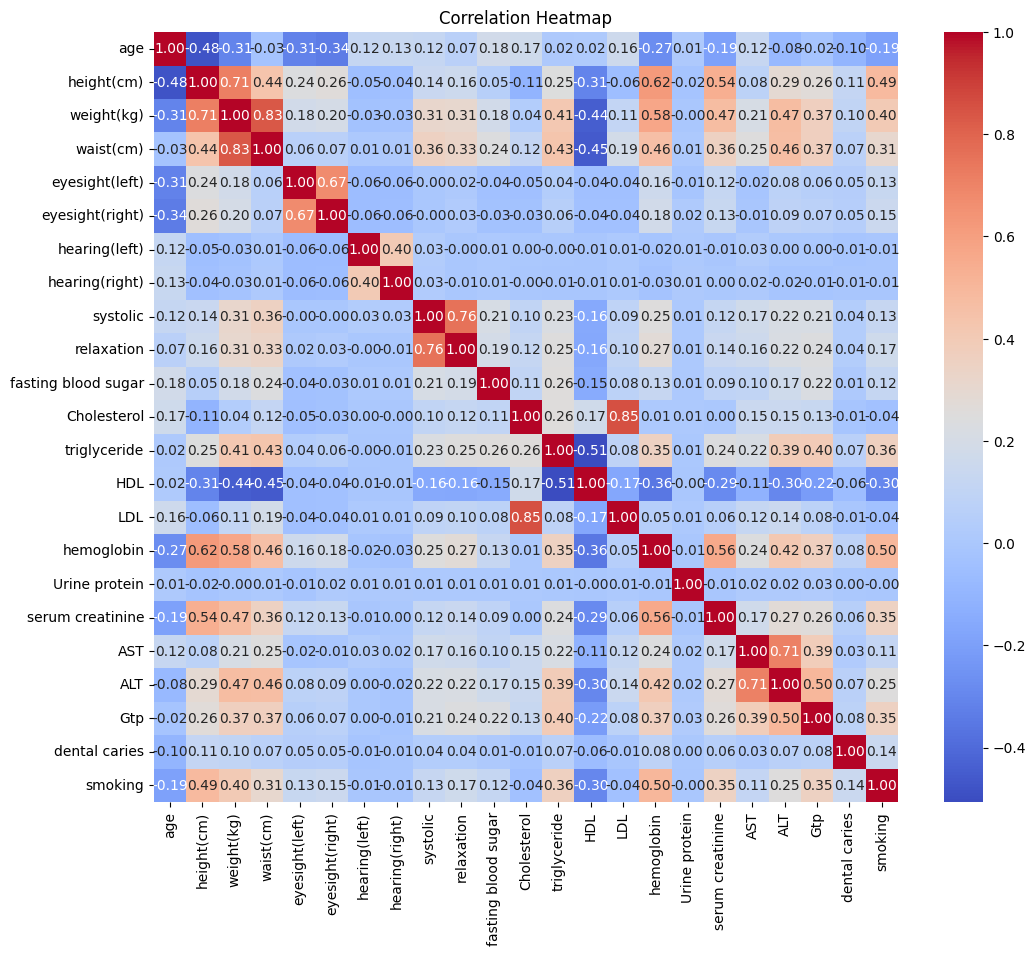

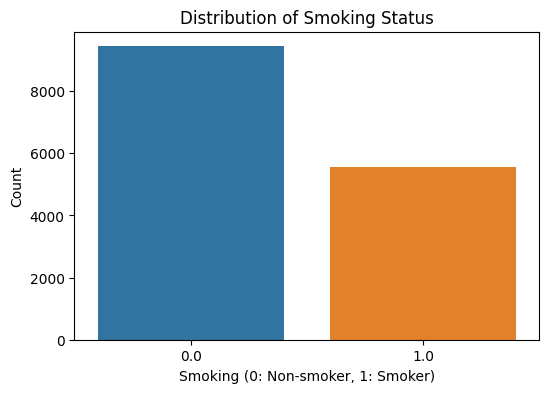

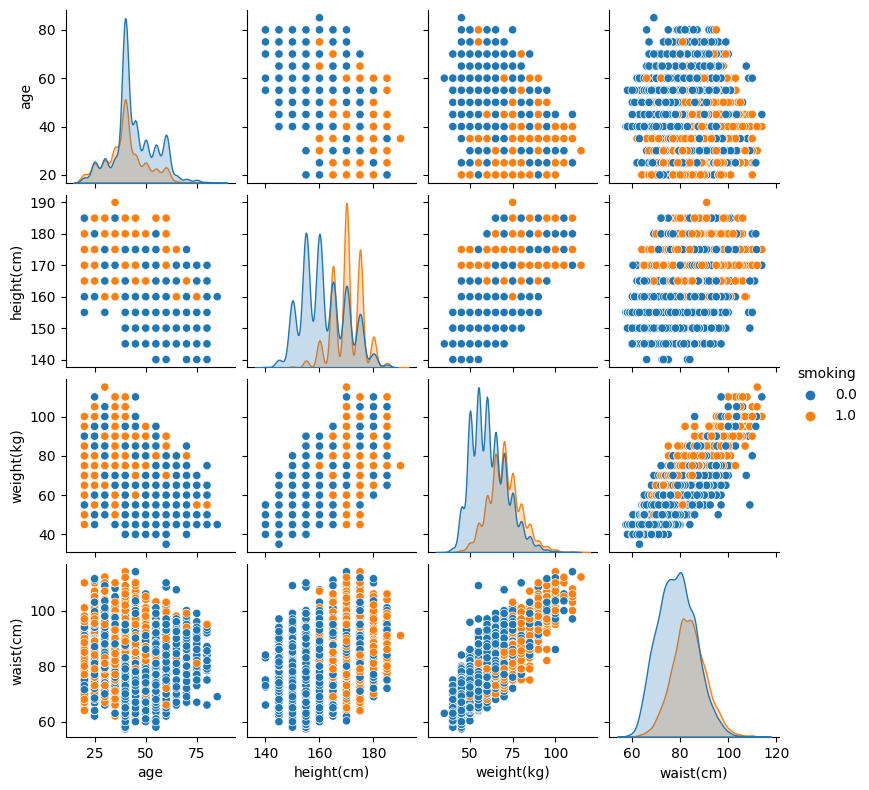

ValueError: num must be an integer with 1 <= num <= 6, not 7

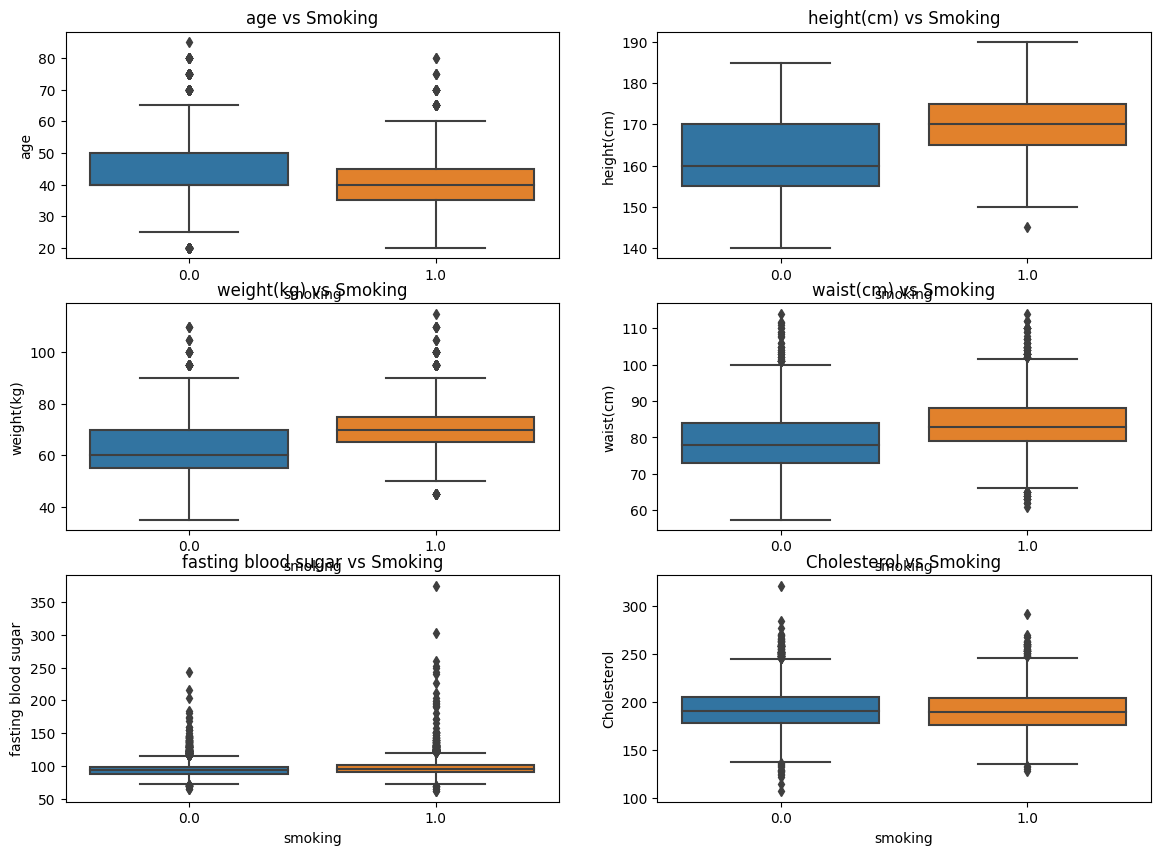

In [52]:
# Матрица корреляций
correlation_matrix = train_df.drop(columns=["id"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Распределение целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x="smoking", data=train_df)
plt.title("Distribution of Smoking Status")
plt.xlabel("Smoking (0: Non-smoker, 1: Smoker)")
plt.ylabel("Count")
plt.show()

# Pairplot
selected_features = ["age", "height(cm)", "weight(kg)", "waist(cm)", "smoking"]
sns.pairplot(train_df[selected_features], hue="smoking", diag_kind="kde", height=2)
plt.show()

# Boxplot
numerical_features = [
    "age",
    "height(cm)",
    "weight(kg)",
    "waist(cm)",
    "fasting blood sugar",
    "Cholesterol",
    "hemoglobin"
]
plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x="smoking", y=feature, data=train_df)
    plt.title(f"{feature} vs Smoking")
plt.tight_layout()
plt.show()


### Корреляции:

Некоторые признаки имеют сильные корреляции, например, между весом, талией и возрастом.

### Распределение целевой переменной:

Дисбаланс классов незначительный, что хорошо для обучения.

### Связь признаков с целевой переменной:

Такие признаки, как возраст, талия и вес, показывают различия между курильщиками и некурильщиками.

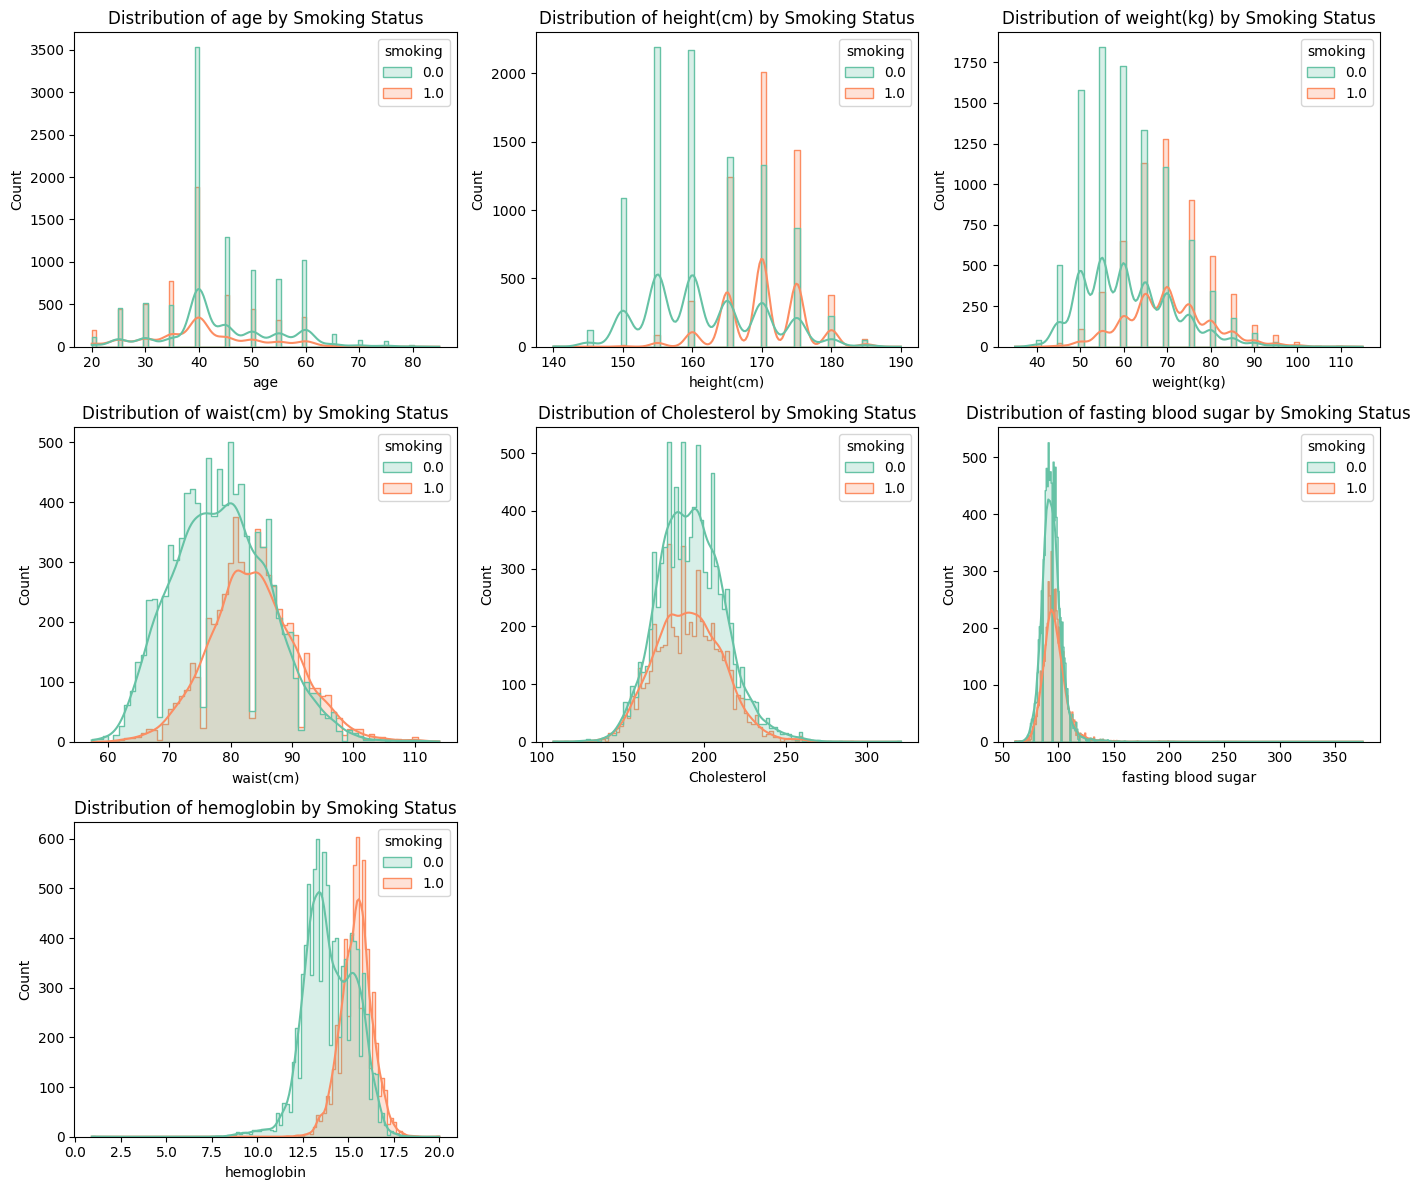

In [55]:
# Ключевые перевенные для анализа
key_features = ["age", "height(cm)", "weight(kg)", "waist(cm)", "Cholesterol", "fasting blood sugar", "hemoglobin"]


plt.figure(figsize=(14, 12))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=train_df, x=feature, hue="smoking", kde=True, element="step", palette="Set2")
    plt.title(f"Distribution of {feature} by Smoking Status")
    plt.xlabel(feature)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

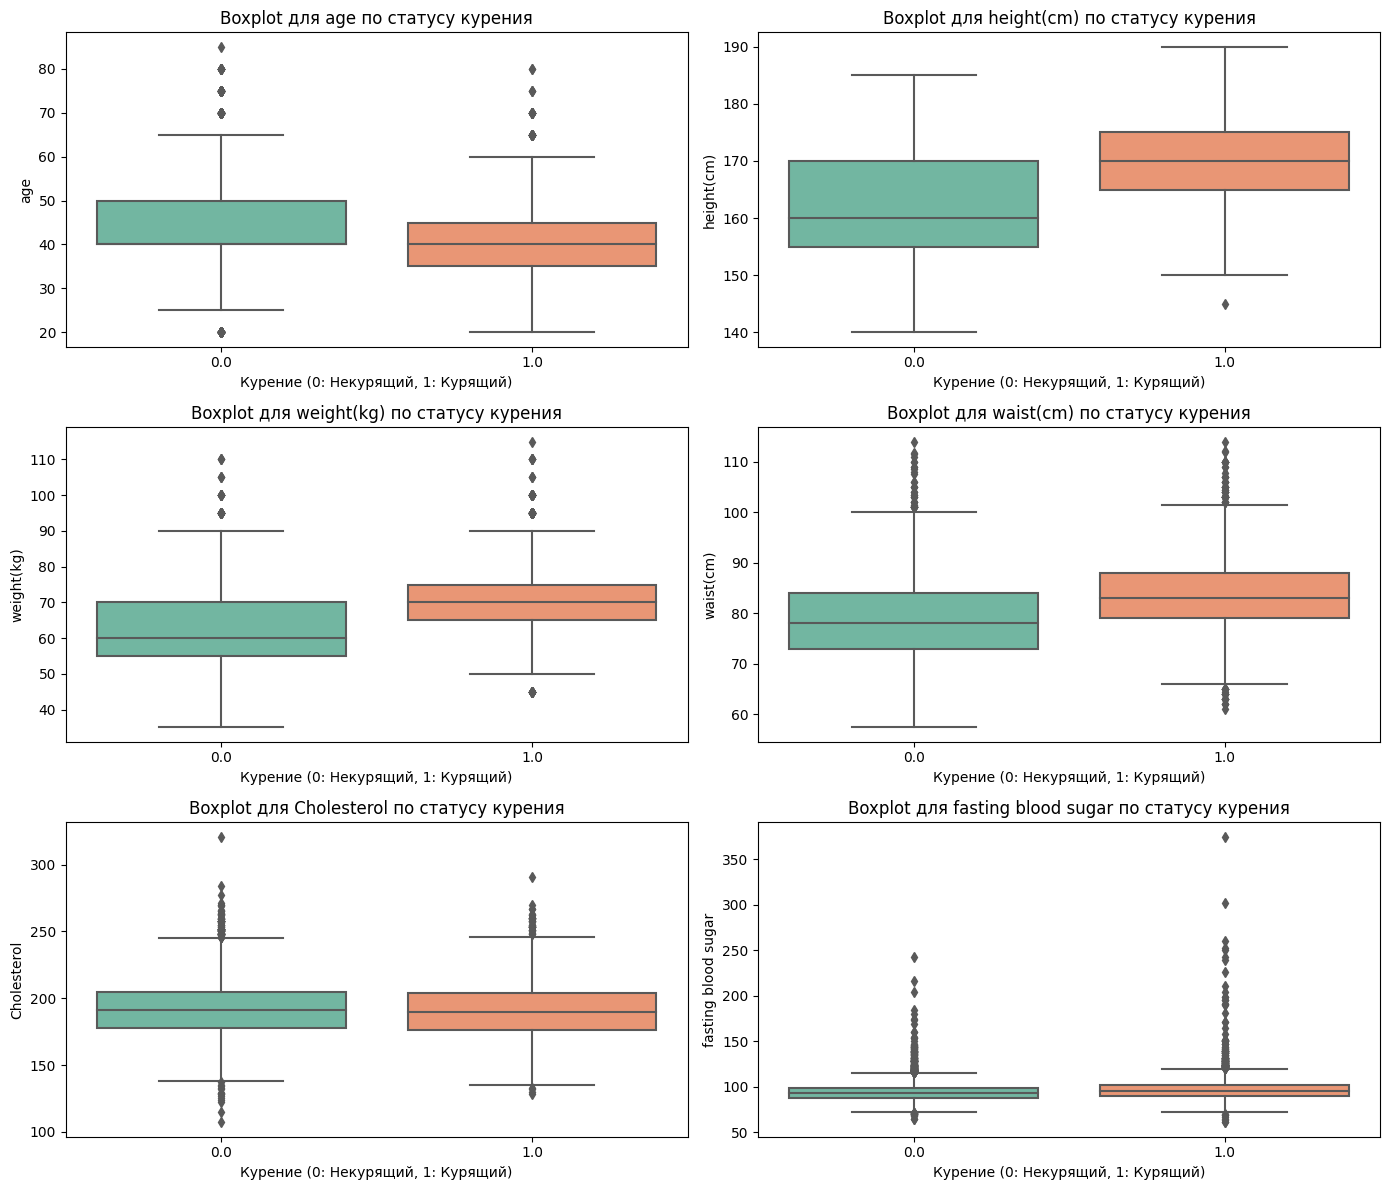

In [53]:
# 1. Проверка выбросов с помощью boxplot
plt.figure(figsize=(14, 12))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 2, i)
    # Построение boxplot для каждого признака
    sns.boxplot(data=train_df, x="smoking", y=feature, palette="Set2")
    plt.title(f"Boxplot для {feature} по статусу курения")
    plt.xlabel("Курение (0: Некурящий, 1: Курящий)")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

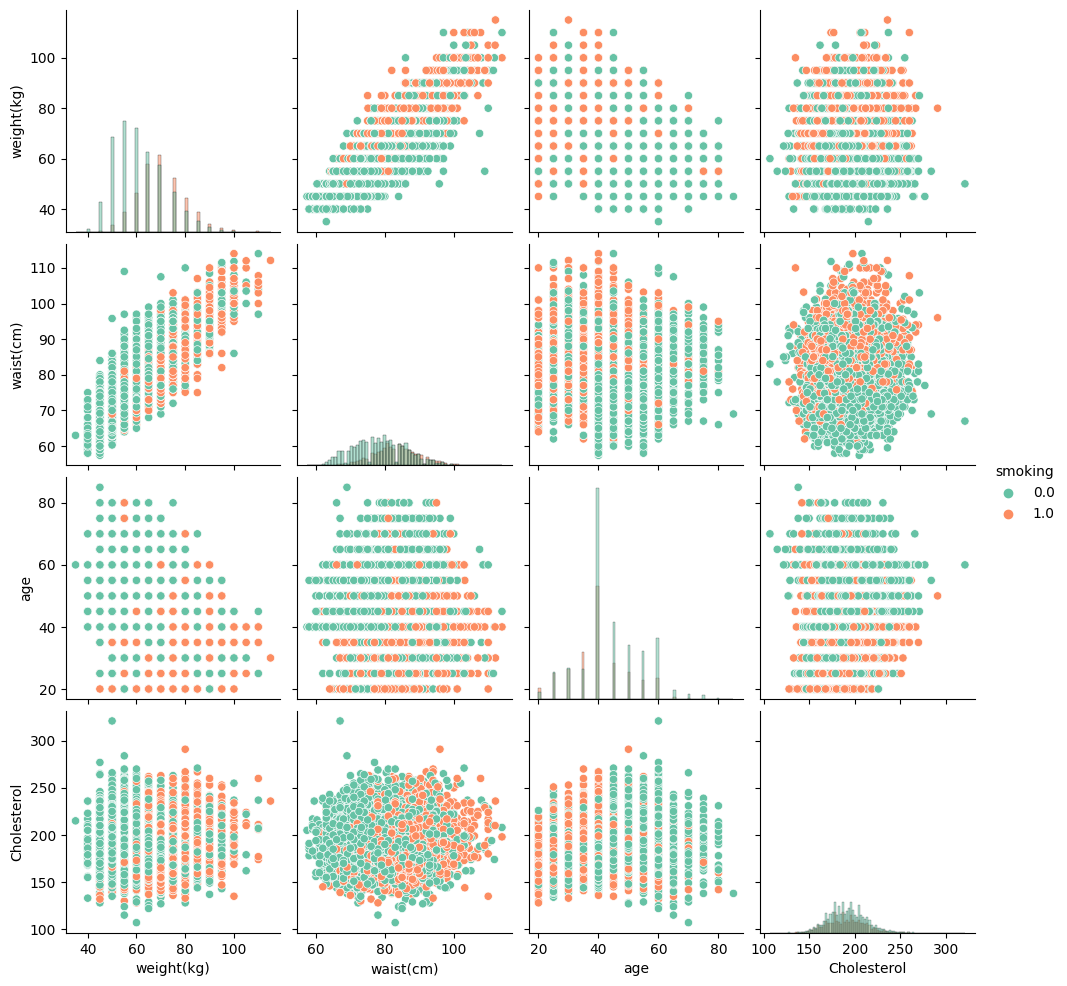

In [7]:
# 2. Глубокий анализ взаимосвязей между признаками (scatterplots)
pair_features = ["weight(kg)", "waist(cm)", "age", "Cholesterol"]
sns.pairplot(
    train_df[pair_features + ["smoking"]],
    hue="smoking",
    palette="Set2",
    diag_kind="hist",  # Использование гистограмм на диагонали
    height=2.5,
)
plt.show()



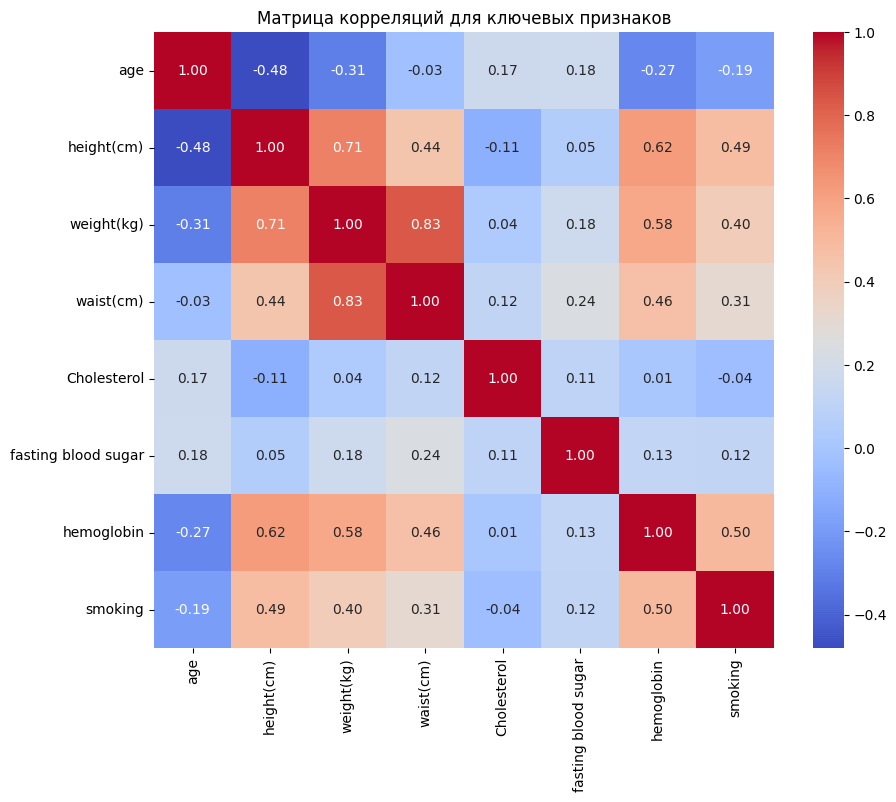

In [56]:
# 3. Матрица корреляций для ключевых признаков
key_correlation_matrix = train_df[key_features + ["smoking"]].corr()

plt.figure(figsize=(10, 8))
# Построение тепловой карты корреляций
sns.heatmap(key_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Матрица корреляций для ключевых признаков")
plt.show()



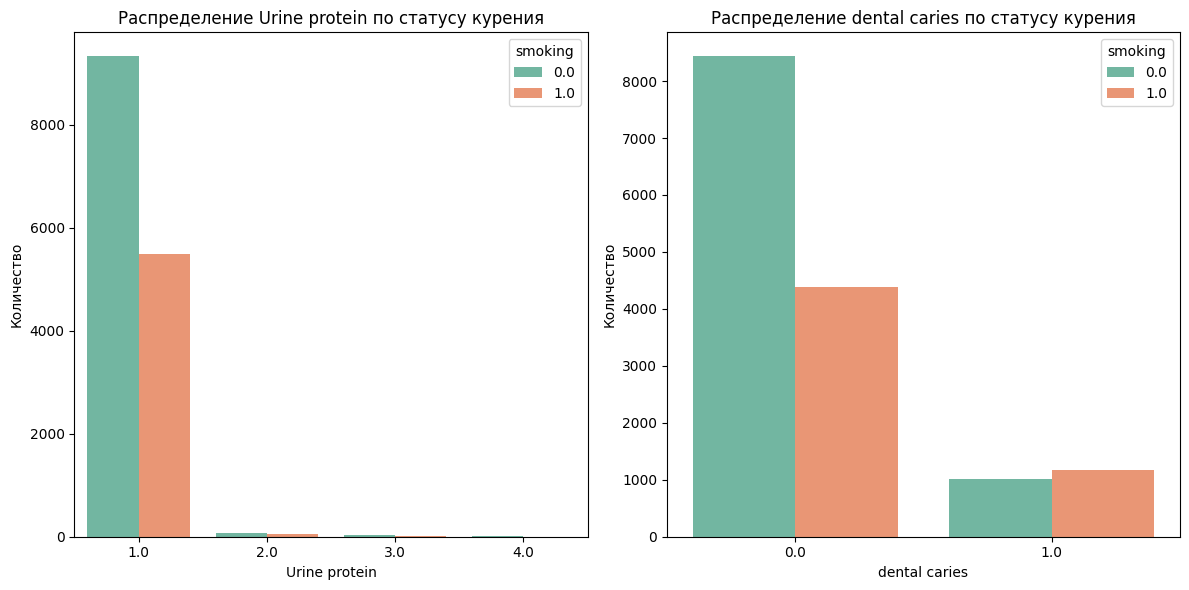

In [9]:
# 4. Проверка распределения категориальных признаков (если такие есть)
categorical_features = ["Urine protein", "dental caries"]  # Предполагаемые категориальные признаки
plt.figure(figsize=(12, 6))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 2, i)
    # Построение countplot для категориальных признаков
    sns.countplot(data=train_df, x=feature, hue="smoking", palette="Set2")
    plt.title(f"Распределение {feature} по статусу курения")
    plt.xlabel(feature)
    plt.ylabel("Количество")

plt.tight_layout()
plt.show()

### Выбросы:

Некоторые признаки, такие как объем талии, уровень холестерина и вес, имеют значительные выбросы, особенно среди курильщиков.
Эти выбросы могут быть учтены при предобработке данных, чтобы минимизировать их влияние на модель.

### Взаимосвязь признаков:

Замечена сильная положительная корреляция между весом и объемом талии.
Возраст также частично коррелирует с некоторыми признаками, такими как холестерин.

### Корреляция с целевой переменной:

Признаки, такие как объем талии, вес, уровень холестерина и возраст, имеют более сильные связи с целевой переменной smoking.
Эти признаки могут быть ключевыми для обучения модели.
Категориальные признаки:

Например, наличие кариеса (dental caries) не показывает сильного разделения между курильщиками и некурильщиками.
Однако "белок в моче" (Urine protein) имеет небольшие различия.

### Ключевые переменные для обучения:

На основе корреляции с целевой переменной smoking были выделены следующие признаки:

С положительной корреляцией:

- hemoglobyne (0.50) - гемоглобин
- weight(kg) (0.40) — вес.
- triglyceride (0.36) — триглицериды.
- Gtp (0.35) — гамма-глутамилтрансфераза.
- waist(cm) (0.31) — объем талии.
- fasting blood sugar (0.12) — уровень сахара натощак.

С отрицательной корреляцией:

- HDL (-0.30) — липопротеины высокой плотности.
- age (-0.19) — возраст.
- LDL (-0.04) — липопротеины низкой плотности.
- Cholesterol (-0.04) — уровень холестерина.

### Нормализация данных

In [57]:
# Список отобранных ключевых признаков
selected_features = [
    "weight(kg)",
    "triglyceride",
    "Gtp",
    "waist(cm)",
    "fasting blood sugar",
    "HDL",
    "age",
    "LDL",
    "Cholesterol",
    "hemoglobin"
]

# 1. Удалим ненужные столбцы из обучающего и тестового наборов
X_train = train_df[selected_features]
y_train = train_df["smoking"]
X_test = test_df[selected_features]

# 2. Нормализация данных (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразуем обратно в DataFrame для удобства анализа
X_train_preprocessed = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_preprocessed = pd.DataFrame(X_test_scaled, columns=selected_features)

# 3. Проверим данные после нормализации
X_train_preprocessed.describe(), X_test_preprocessed.describe()

(         weight(kg)  triglyceride  ...   Cholesterol    hemoglobin
 count  15000.000000  15000.000000  ...  15000.000000  15000.000000
 mean       0.367717      0.209538  ...      0.393578      0.712910
 std        0.137507      0.128737  ...      0.095502      0.073552
 min        0.000000      0.000000  ...      0.000000      0.000000
 25%        0.250000      0.122667  ...      0.327103      0.659686
 50%        0.375000      0.176000  ...      0.392523      0.722513
 75%        0.437500      0.258667  ...      0.457944      0.769634
 max        1.000000      1.000000  ...      1.000000      1.000000
 
 [8 rows x 10 columns],
          weight(kg)  triglyceride  ...   Cholesterol    hemoglobin
 count  10000.000000  10000.000000  ...  10000.000000  10000.000000
 mean       0.366013      0.207456  ...      0.393596      0.713008
 std        0.138387      0.125530  ...      0.094244      0.073121
 min        0.000000     -0.008000  ...      0.056075      0.335079
 25%        0.250000  

### Построение нейросети

In [58]:
# Проверка на наличие GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [90]:
# Подготовка данных для PyTorch
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train_full, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_full.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_full, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_full.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

In [60]:
# Создание DataLoader для обучающего набора данных
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [150]:
# Архитектура модели
class BottleneckBlock(nn.Module):
    def __init__(self, in_dim, bottleneck_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, bottleneck_dim)
        self.bn1 = nn.BatchNorm1d(bottleneck_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(bottleneck_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.skip = nn.Linear(in_dim, out_dim) if in_dim != out_dim else None
    def forward(self, x):
        r = x
        x = self.fc1(x); x = self.bn1(x); x = self.relu(x)
        x = self.fc2(x); x = self.bn2(x)
        if self.skip: r = self.skip(r)
        x = x + r
        x = self.relu(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads, dropout, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.ReLU(),
            nn.Linear(d_model*4, d_model)
        )
        self.ln2 = nn.LayerNorm(d_model)
    def forward(self, x):
        a, _ = self.attn(x, x, x)
        x = x + self.drop(a); x = self.ln1(x)
        f = self.ffn(x)
        x = x + self.drop(f); x = self.ln2(x)
        return x

class EnhancedGRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers_gru, num_transformer_blocks,
                 transformer_heads, dropout):
        super().__init__()
        self.in_proj = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.bottleneck1 = BottleneckBlock(512, 256, 512)
        self.gru = nn.GRU(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=num_layers_gru,
            dropout=dropout if num_layers_gru > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )
        dim_after_gru = hidden_size*2
        self.transformers = nn.ModuleList([
            TransformerBlock(dim_after_gru, transformer_heads, dropout)
            for _ in range(num_transformer_blocks)
        ])
        self.bottleneck2 = BottleneckBlock(dim_after_gru, dim_after_gru//2, 128)
        self.out_proj = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = self.in_proj(x)
        x = self.bottleneck1(x)
        x = x.unsqueeze(1)
        x, _ = self.gru(x)
        for block in self.transformers:
            x = block(x)
        x = x.squeeze(1)
        x = self.bottleneck2(x)
        x = self.out_proj(x)
        return x

In [152]:
# Обучение модели
def train_model(trial):
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 30, 80, step=10)
    hidden_size = trial.suggest_int("hidden_size", 256, 512, step=256)
    num_layers_gru = trial.suggest_int("num_layers_gru", 1, 3)
    num_transformer_blocks = trial.suggest_int("num_transformer_blocks", 1, 3)
    transformer_heads = trial.suggest_int("transformer_heads", 4, 8, step=4)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = EnhancedGRUClassifier(
        input_dim=X_train_tensor.shape[1],
        hidden_size=hidden_size,
        num_layers_gru=num_layers_gru,
        num_transformer_blocks=num_transformer_blocks,
        transformer_heads=transformer_heads,
        dropout=dropout_rate
    ).to(device)
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    sched = CosineAnnealingWarmRestarts(opt, T_0=5, T_mult=2)
    loss_fn = nn.BCEWithLogitsLoss()

    best_acc = 0
    for epoch in range(num_epochs):
        model.train()
        for i, (Xb, yb) in enumerate(loader):
            opt.zero_grad()
            out = model(Xb).squeeze()
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
            # Шаг для корректной работы CosineAnnealingWarmRestarts
            sched.step(epoch + i/len(loader))

        model.eval()
        with torch.no_grad():
            pred = model(X_val_tensor).squeeze()
            pred_bin = (torch.sigmoid(pred) >= 0.5).int().cpu().numpy()
            acc = accuracy_score(y_val_tensor.cpu().numpy(), pred_bin)
        if acc > best_acc:
            best_acc = acc
    return best_acc

In [121]:
# Оптимизация гиперпараметров с помощью Optuna
def optimize():
    study = optuna.create_study(direction="maximize")
    study.optimize(train_model, n_trials=50)
    print("Лучший вариант:")
    print("  Точность:", study.best_trial.value)
    print("  Параметры:")
    for k, v in study.best_trial.params.items():
        print("   ", k, v)
    return study

In [ ]:
study = optimize() 
p = study.best_params

In [ ]:
final_model = EnhancedGRUClassifier(
    input_dim=X_train_tensor.shape[1],
    hidden_size=p["hidden_size"],
    num_layers_gru=p["num_layers_gru"],
    num_transformer_blocks=p["num_transformer_blocks"],
    transformer_heads=p["transformer_heads"],
    dropout=p["dropout"]
).to(device)

In [ ]:
opt = optim.AdamW(final_model.parameters(), lr=p["lr"], weight_decay=1e-5)
sched = CosineAnnealingWarmRestarts(opt, T_0=5, T_mult=2)
loss_fn = nn.BCEWithLogitsLoss()
final_loader = DataLoader(dataset, batch_size=p["batch_size"], shuffle=True)

In [159]:
# Обучение финальной модели с лучшими параметрами
best_acc = 0
for epoch in range(p["num_epochs"]):
    final_model.train()
    for i, (Xb, yb) in enumerate(final_loader):
        opt.zero_grad()
        out = final_model(Xb).squeeze()
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        sched.step(epoch + i/len(final_loader))

    final_model.eval()
    with torch.no_grad():
        pred = final_model(X_val_tensor).squeeze()
        pred_bin = (torch.sigmoid(pred) >= 0.5).int().cpu().numpy()
        acc = accuracy_score(y_val_tensor.cpu().numpy(), pred_bin)
    if acc > best_acc:
        best_acc = acc

    print(f"Эпоха {epoch+1}/{p['num_epochs']}, Точн.: {acc:.4f}, Лучшая: {best_acc:.4f}")

Epoch 1/100, Loss: 90.8468, AUC: 0.8578, Best AUC: 0.8578
Epoch 2/100, Loss: 85.9748, AUC: 0.8660, Best AUC: 0.8660
Epoch 3/100, Loss: 84.8642, AUC: 0.8658, Best AUC: 0.8660
Epoch 4/100, Loss: 84.0681, AUC: 0.8648, Best AUC: 0.8660
Epoch 5/100, Loss: 84.1707, AUC: 0.8675, Best AUC: 0.8675
Epoch 6/100, Loss: 83.0620, AUC: 0.8683, Best AUC: 0.8683
Epoch 7/100, Loss: 83.8522, AUC: 0.8673, Best AUC: 0.8683
Epoch 8/100, Loss: 82.5592, AUC: 0.8674, Best AUC: 0.8683
Epoch 9/100, Loss: 82.1052, AUC: 0.8682, Best AUC: 0.8683
Epoch 10/100, Loss: 82.2864, AUC: 0.8691, Best AUC: 0.8691
Epoch 11/100, Loss: 82.0565, AUC: 0.8708, Best AUC: 0.8708
Epoch 12/100, Loss: 81.9166, AUC: 0.8677, Best AUC: 0.8708
Epoch 13/100, Loss: 81.9811, AUC: 0.8690, Best AUC: 0.8708
Epoch 14/100, Loss: 81.5499, AUC: 0.8709, Best AUC: 0.8709
Epoch 15/100, Loss: 81.7480, AUC: 0.8692, Best AUC: 0.8709
Epoch 16/100, Loss: 81.7686, AUC: 0.8683, Best AUC: 0.8709
Epoch 17/100, Loss: 81.4918, AUC: 0.8698, Best AUC: 0.8709
Epoch 

P.S. экспериментально установил, что 21 эпоха оптимальна. Подбор по количеству эпох делать не стал т.к. ресурсозатратно

In [160]:
# Прогнозы для тестового набора
final_model.eval()
y_test_pred = torch.sigmoid(final_model(X_test_tensor).squeeze()).detach().cpu().numpy()

In [161]:
# Сохранение результатов в файл
submission = pd.DataFrame({"id": test_df["id"], "smoking": y_test_pred})
submission.to_csv("submission.csv", index=False)
print("Submission file saved: submission.csv")

Submission file saved: submission.csv
